## Import relevant modules

In [11]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mt
import seaborn as sns
import numpy as np
import datetime as dt
import math
import psycopg2
import statsmodels.api as sm
import brewer2mpl
import pickle
import sklearn
from sklearn.model_selection import train_test_split

## Query the MIMIC database for relevant patient information

In [4]:
conn = psycopg2.connect(dbname="mimic", user="pradeepbandaru", password="RasRafB2H")

# calculate patient age at admission and store along with select columns from icustays table
icustays_query = """SELECT ie.subject_id, ie.hadm_id, ie.icustay_id,
ie.intime, ie.outtime, ie.first_careunit,
date_part('day', pat.dod_hosp - ie.intime) AS survival_days,
ROUND((cast(ie.intime as date) - cast(pat.dob as date))/365.242, 2) AS age_admit
FROM mimiciii.icustays ie
INNER JOIN mimiciii.patients pat
ON ie.subject_id = pat.subject_id;
"""
# WHERE pat.expireflag = 1

# calculate patient age at death and store along with select columns from admissions table
admissions_query = """SELECT ad.subject_id, ad.hadm_id, ad.deathtime,
ad.insurance, ad.language, ad.religion, ad.marital_status, ad.admission_type,
case
    when ad.ethnicity like '%WHITE%' then 'WHITE'
    when ad.ethnicity like '%BLACK%' then 'BLACK'
    when ad.ethnicity like '%HISPANIC%' then 'HISPANIC'
    when ad.ethnicity like '%ASIAN%' then 'ASIAN'
    else 'OTHER' end as ethnicity,
ad.hospital_expire_flag,
ROUND((cast(ad.deathtime as date) - cast(pat.dob as date))/365.242, 2) AS age_death
FROM mimiciii.admissions ad
INNER JOIN mimiciii.patients pat
ON ad.subject_id = pat.subject_id
"""

# select columns from diagnoses_icd table
diagnoses_icd_query = """SELECT di.subject_id, di.hadm_id, di.icd9_code  
FROM mimiciii.diagnoses_icd di"""

# select columns from patients table
patients_query = """SELECT pat.subject_id, pat.gender FROM mimiciii.patients pat"""

# execute SQL queries and store in pandas dataframes
icustays_table = pd.read_sql_query(icustays_query,conn)
admissions_table = pd.read_sql_query(admissions_query,conn)
diagnoses_icd_table = pd.read_sql_query(diagnoses_icd_query,conn)
patients_table = pd.read_sql_query(patients_query,conn)

In [5]:
# combine all tables into one master table per patient
dfs = [icustays_table, admissions_table, diagnoses_icd_table, patients_table]
master = reduce(lambda left,right: pd.merge(left,right,on='subject_id'), dfs)
master = master.drop_duplicates(subset=['subject_id', 'hadm_id'])

# get rid of unwanted columns
cols = ['hadm_id_y', 'hadm_id', 'intime', 'outtime', 'deathtime']
master.drop(cols, inplace=True, axis=1)

## Filter master patient table by disease-specific ICD9 codes

In [6]:
#master.head(15)
#print df_final.shape

# filter the master table by patients who have died in the hospital
#master2 = master.query('age_admit > 100')
master2 = master[master.age_admit > 100]

#filter the master table by icd9 codes that correspond to AKI or MI
#MI:
master2 = master.loc[master['icd9_code'].isin(['41011', '41091', '412', '4139', '41401', '41400', '41000', '41010'])]

#AKI:
#master2 = master.loc[master['icd9_code'].isin(['5939', '5845', '5846', '5847', '5848', '5849'])]
#master2.head(20)
#master2.shape
#make some plots from the master table

## Make some plots of the data

In [5]:
# Set up some better defaults for matplotlib
from matplotlib import rcParams

#colorbrewer2 Dark2 qualitative color table
dark2_colors = brewer2mpl.get_map('Dark2', 'Qualitative', 7).mpl_colors

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
#rcParams['axes.prop_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'white'
rcParams['patch.facecolor'] = dark2_colors[0]
rcParams['font.family'] = 'StixGeneral'


def remove_border(axes=None, top=False, right=False, left=True, bottom=True, ax = None):
    """
    Minimize chartjunk by stripping out unnecesasry plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    if ax == None:
        ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()

In [6]:
#p = master2[['age_admit','gender']].groupby('gender').boxplot(return_type='axes')
# master2['survival_days'].value_counts()
# sns.countplot(x='survival_days',data=master2, palette='hls')
# plt.show()

In [7]:
# number of men and women
#print master2.gender.value_counts()

#counts by ICU
#pd.crosstab(master2.first_careunit, master2.gender)

#master2.to_csv('~/Desktop/data.csv')

In [8]:
# pd.crosstab(master2.age_admit,master2.survival_days).plot(kind='bar')
# plt.title('Purchase Frequency for Job Title')
# plt.xlabel('Job')
# plt.ylabel('Frequency of Purchase')

In [9]:
#pd.crosstab(master2.insurance, master2.gender)

## Train a regression model

In [7]:
# remove missing data
#master2 = master2.dropna(axis=0)

# create dummy variables for parameters and one-hot encode categorical variables
dummy_list = ['age_admit', 'gender', 'first_careunit', 'marital_status', 'ethnicity', 'admission_type', 'insurance']
dummy_frames = [pd.get_dummies(master2[x]) for x in dummy_list]
dummy_frames = pd.concat(dummy_frames, axis=1)
#master2.shape

In [8]:
master2['year_die'] = (master2.survival_days < 365).astype(int)
master3 = pd.concat([master2, dummy_frames], axis=1)
master3['intercept'] = 1.0
# train_cols = ['intercept','age_admit', 'CSRU', 'MICU', 'SICU', 'CCU', 
#              'DIVORCED', 'MARRIED', 'SEPARATED', 'WIDOWED', 'SINGLE', 
#              'ASIAN', 'BLACK', 'HISPANIC', 'WHITE', 
#              'EMERGENCY', 'URGENT',
#              'Medicaid', 'Medicare', 'Private', 'Government']


# MI features
train_cols = ['intercept','age_admit', 
             'M',
             'CCU', 'CSRU',
             'DIVORCED', 'MARRIED', 'WIDOWED', 'SINGLE', 
             'ASIAN', 'BLACK', 'HISPANIC', 'WHITE', 
             'EMERGENCY', 'URGENT',
             'Medicaid', 'Medicare']


# AKI features
# train_cols = ['intercept','age_admit', 
#              'MICU', 'SICU', 'CCU', 
#              'DIVORCED', 'MARRIED', 'WIDOWED', 'SINGLE', 
#              'ASIAN', 'BLACK', 'HISPANIC', 'WHITE', 
#              'EMERGENCY', 'URGENT',
#              'Medicaid', 'Medicare']

/Users/pradeepbandaru/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [19]:
logit = sm.Logit(master3.year_die, master3[train_cols])
result = logit.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.182062
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               year_die   No. Observations:                 4105
Model:                          Logit   Df Residuals:                     4088
Method:                           MLE   Df Model:                           16
Date:                Thu, 27 Sep 2018   Pseudo R-squ.:                  0.1402
Time:                        11:12:12   Log-Likelihood:                -747.37
converged:                       True   LL-Null:                       -869.24
                                        LLR p-value:                 9.918e-43
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -3.2012      0.462     -6.925      0.000      -4.107      -2.295
age_admit      0.0061      0.001      4.923      0.000       0.004       0.009
M             -0.1348      0.164     -0.824      0.410      -0.456       0.186
CCU            0.1757      0.256      0.686      0.493      -0.327       0.678
CSRU          -1.3210      0.275     -4.810      0.000      -1.859      -0.783
DIVORCED       0.1253      0.396      0.316      0.752      -0.652       0.902
MARRIED       -0.2450      0.286     -0.857      0.391      -0.805       0.315
WIDOWED       -0.3681      0.327     -1.127      0.260      -1.008       0.272
SINGLE        -0.3396      0.342     -0.994      0.320      -1.009       0.330
ASIAN          0.5280      0.558      0.946      0.344      -0.566       1.622
BLACK          0.6353      0.342      1.860      0.063      -0.034       1.305
HISPANIC      -0.4133      0.617     -0.669      0.503      -1.624       0.797
WHITE         -0.1901      0.175     -1.084      0.278      -0.534       0.154
EMERGENCY      0.2611      0.218      1.199      0.231      -0.166       0.688
URGENT         0.2259      0.342      0.661      0.509      -0.444       0.896
Medicaid       0.7508      0.381      1.969      0.049       0.003       1.498
Medicare       1.0576      0.195      5.421      0.000       0.675       1.440
==============================================================================
"""

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(master3[train_cols], master3.year_die, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [22]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.95


In [18]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

plt.figure()
plot_confusion_matrix(confusion_matrix, classes=class_names,
                      title='Confusion matrix')

[[1174    0]
 [  58    0]]


NameError: name 'plot_confusion_matrix' is not defined

<Figure size 432x288 with 0 Axes>

In [15]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.95      1.00      0.98      1174
          1       0.00      0.00      0.00        58

avg / total       0.91      0.95      0.93      1232



/Users/pradeepbandaru/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


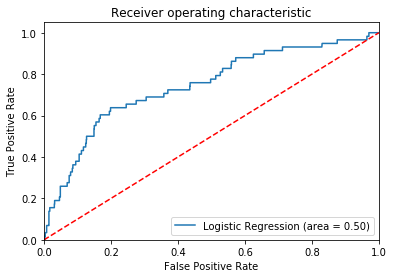

In [16]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## Pickle the dataset and create a web API

In [13]:
#from sklearn.externals import joblib
#joblib.dump(logit, 'model.pkl')

['model.pkl']

In [ ]:
from flask import Flask, jsonify, render_template
app = Flask(__name__)

@app.route("/")
def logreg():
    result = logit.fit()
    data = result.summary()
    return render_template('/Users/pradeepbandaru/Desktop/icu-risk-prediction/templates/dashboard.html', data=data)

if __name__ == "__main__":
    app.run()
    app.debug=True

In [ ]:
logreg()